# Edge of Stability with Associative Memory model

The goal of this notebook is to show edge of stability arising in the associative memory model considered in the paper ``Scaling laws for associative memories''.

In [1]:
import subprocess
from math import sqrt
from random import seed

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

# be mindful of pseudo-random number generator
th.manual_seed(0)

Some of the code will be cast into a `utils.py` file

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('.')

# Part 1: Setup and Training loop

## Model
We define the model.
We take random embeddings of both integer inputs $x$ and integer outputs $y$ as random vectors of the sphere in $\R^d$, respectively $e_x$ and $u_y$.
Then we map $x$ to $y$ through the model $y = f_W(x)$, where $W$ is a matrix of size $d \times d$ to be learned and that parameterizes
$$
    f_W(x) = \argmax_{y} e_x^\top W u_y = \argmax_y \langle e_x, W u_y \rangle.
$$
The natural formula would be
$
    f_W(x) = \argmax_{y} \langle u_y, W e_x \rangle,
$
but because of C memory order, it is more natural to implement it the other way around.

In [4]:
def get_embeddings(n, d, norm=True):
    emb = th.randn(n, d)
    if norm:
        emb /= emb.norm(dim=1, keepdim=True)
    else:
        emb /= sqrt(d)
    return emb


class AssMem(nn.Module):
    def __init__(self, E, U):
        """
        E: torch.Tensor
            Input embedding matrix of size $n \times d$,
            where $n$ is the number of tokens and $d$ is the embedding dimension.
        U: torch.Tensor
            Output unembedding matrix of size $d \times m$,
            where $m$ is the number of classes and $d$ is the embedding dimension.
        """
        super().__init__()
        d = E.shape[1]
        self.W = nn.Parameter(th.zeros(d, d))
        # self.W = nn.Parameter(th.randn(d, d) / sqrt(d))
        self.E = E
        self.UT = U.T

    def forward(self, x):
        """
        Compute the score :math:`g(x, y) = u_y^\top W e_x`.
        """
        emb = self.E[x]
        if emb.size(0) < self.UT.size(1):   # if b < m
            out = emb @ self.W      # (b, d) @ (d, d) -> (b, d)  in O(bd^2)
            out = out @ self.UT     # (b, d) @ (d, m) -> (b, m)  in O(bdm)
        else:
            out = self.W @ self.UT  # (d, d) @ (d, m) -> (d, m)  in O(md^2)
            out = emb @ out         # (b, d) @ (d, m) -> (b, m)  in O(bdm)
        return out

    def fit(self, x):
        """
        Compute the prediction :math:`f(x) = \operatorname{argmax}_y u_y^\top W e_x`.
        """
        score = self.forward(x)
        return score.argmax(dim=1)


## Data
Let's start with a small specification of the model.
Assume that the $y = x$ and the $x$ is taken uniformly at random over $n$ integers.
Later we could consider more complex model such as $y = f(x, \epsilon)$ where $\epsilon$ is a noise term, and $x$ to be non-uniform (which would reduce the "effective dimension").

In [5]:
# number of input tokens
n = 30

# probability of the inputs, a Zipf law of parameter alpha
alpha = 0                 # alpha = 0 means uniform distribution
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()

In [6]:
# association model
def f(x, epsilon=None):
    """
    Model of association between `x` and `y`.
    """
    return x

# noise level
epsilon = 0

# target associations
all_y = f(all_x, 0)

In [7]:
# memory dimension
d = 10

# random embeddings
E = get_embeddings(all_x.max() + 1, d, norm=False)
U = get_embeddings(all_y.max() + 1, d, norm=True)

# model
model = AssMem(E, U)

## Optimization procedure
We will learn the matrix $W$ by gradient descent on a surrogate loss function.
We use the softmax loss (which is convex in $W$)
$$
    \ell(W; x, y) = \log \left( \sum_{z} \exp \langle e_x, W u_z \rangle \right) - \langle e_x, W u_y \rangle.
$$
We begin with a constant step size $\eta$, and batch size equals one.
We begin with a constant step size $\eta$, and batch size equals one.
We could easily change the code to try out other optimization procedures.

In [8]:
# optimization parameter 
batch_size = 1
nb_epoch = 10000
T = nb_epoch * batch_size
lr = 1e-3

optimizer = th.optim.SGD(model.parameters(), lr=lr, momentum=0)
# scheduler = th.optim.lr_scheduler.StepLR(optimizer, nb_epoch // 10, gamma=0.1)

In [9]:
# training loop 

train_loss = th.zeros(nb_epoch)
test_loss = th.zeros(nb_epoch)

for i in range(nb_epoch):
    # get batch of data
    x = th.multinomial(proba, batch_size, replacement=True)
    y = f(x, epsilon)

    # compute loss
    score = model(x)
    loss = F.cross_entropy(score, y)
    
    # record statistics
    train_loss[i] = loss.item()
    with th.no_grad():
        pred = model.fit(all_x)
        test_loss[i] = proba[pred != all_y].sum().item()

    # update parameters with gradient descent
    loss.backward()
    optimizer.step()
    # scheduler.step()


## Visualization

We configure matplotlib to render nicely in a TeX file by notably compute the width of figures exactly (rather than resizing it in TeX).
You can find width of a LaTeX documents with \the\textwidth, and the font size with \expandafter\string\the\font
Here I assume that we use the `times` font with a size of 12pt, and a document of width 6.5in (or 472 pt).

In [10]:
width = 472 / 72

plt.rc('font', family='serif', size=12)
usetex = not subprocess.run(['which', 'pdflatex']).returncode
plt.rc('text', usetex=usetex)
if usetex:
    plt.rc('text.latex', preamble=r'\usepackage{times}')

/home/vivc/.local/share/texlive/2022/bin/x86_64-linux/pdflatex


To average out the noise in the training procedure, we can use an exponential moving average

In [11]:
@th.jit.script
def ewma(x: th.Tensor, theta: float):
    r = th.zeros_like(x)
    r[0] = x[0]
    for i in range(1, x.shape[0]):
        r[i] = theta * r[i - 1] + (1 - theta) * x[i]
    return r

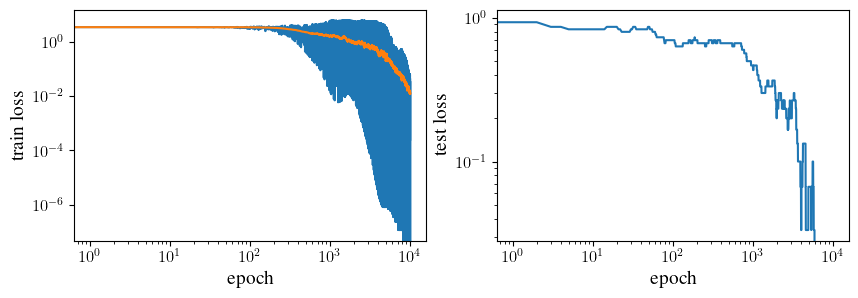

In [12]:
# # for TeX documents
# fig, ax = plt.subplots(1, 1, figsize=(.48 * width, .48 * width / 1.618))
# for visualization ease in this notebook
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(th.arange(nb_epoch), train_loss, label='train')
smooth_train_loss = ewma(train_loss, .99)
axes[0].plot(th.arange(nb_epoch), smooth_train_loss, label='train')
axes[1].plot(th.arange(nb_epoch), test_loss, label='test')

for i in range(2):
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel('epoch', fontsize=14)
    loss_type = {0: "train", 1: "test"}[i]
    axes[i].set_ylabel(f'{loss_type} loss', fontsize=14)

# fig.savefig('eos_first_plot.pdf', bbox_inches='tight', pad_inches=0)

# Part 2: Profiling the training to analyze it

## Training Dynamics Logging
In order to better understand the dynamics of the optimization, we will monitor quantities related to the gradient and the Hessian of the loss function.
Note that the softmax loss can be understood as a cross-entropy loss between the model probability and the empirical probability, or the inverse log-likelihood of the model probability.
$$
    \ell(W; x, y) = -\log p_W(y \,\vert\, x), \qquad\text{where}\qquad
    p_W(y \,\vert\, x) = \frac{\exp \langle e_x, W u_y \rangle}{\sum_{z} \exp \langle e_x, W u_z \rangle}.
$$

The gradient is easy to compute with simple rules:
$$
    \nabla \ell(W; x, y) 
    = \nabla \log \left( \sum_{z} \exp \langle e_x, W u_z \rangle \right) - \nabla \langle e_x, W u_y \rangle
    = \sum_{z} \frac{\exp \langle e_x, W u_z \rangle}{\sum_{z'} \exp \langle e_x, W u_{z'} \rangle} e_x u_z^\top  - e_x u_y^\top
    = \sum_{z} p_W(z\,\vert\, x) e_x u_z^\top - e_x u_y^\top.
$$

Now, notice that when the gradient can be written as
$$
    \nabla \ell(\theta) = g(\theta) \cdot a = (\partial_i \ell(\theta))_{i}, \qquad\text{with}\qquad g(\theta) \in \R,\quad a \in \R^d,
$$
the Hessian follows as
$$
    \nabla^2 \ell(\theta) = (\partial_{ij}\ell(\theta)) = (\partial_i\partial_j \ell(\theta)) = (\partial_i g(\theta)\, a_j) = (\nabla g(\theta))\,a^\top.
$$
In our case, we want to use the Euclidean structure on the matrix space, which leads to
$$
    \nabla^2 \ell(W; x, y) = \sum_{z} \nabla p_W(z\,\vert\, x) (e_x \otimes u_z)^\top.
$$
To compute $\nabla p_W(z\,\vert\, x)$, notice that we could equally have expressed the loss gradient as
$$
    \nabla \ell(W; x, y) = -\nabla \log p_W(y\,\vert\,x) = -\frac{\nabla p_W(y\,\vert\,x)}{p_W(y\,\vert\, x)},
$$
from which we deduce that
$$
    \nabla p_W(z\,\vert\,x) = - p_W(z\,\vert\, x) \nabla \ell(W; x, z)
    = p_W(z\,\vert\, x)\left(e_x \otimes u_z - \sum_{z'} p_W(z'\,\vert\, x) e_x \otimes u_{z'} \right).
$$
We are left with
$$
    \nabla^2 \ell(W; x, y) = \sum_{z} \nabla p_W(z\,\vert\, x) (e_x \otimes u_z )^\top
    =  \sum_{z}\left(p_W(z\,\vert\, x)\left(e_x \otimes u_z - \sum_{z'} p_W(z'\,\vert\, x) e_x \otimes u_{z'} \right)\right) (e_x \otimes u_z)^\top.
$$
This can be developed as
$$
    \nabla^2 \ell(W; x, y) = \sum_{z} p_W(z\,\vert\, x) (e_x \otimes u_z)(e_x\otimes u_z)^\top - \sum_{z, z'} p_W(z\,\vert\, x) p_W(z'\,\vert\, x) (e_x\otimes u_z)(e_x\otimes u_{z'})^\top
    = \sum_{z,z'} p_W(z\,\vert\, x) (\delta_{z,z'} - p_W(z'\,\vert\, x)) e_x\otimes u_z\otimes e_x\otimes u_{z'}.
$$
It would be reassuring to check that this Hessian is symmetric and positive semi-definite.
It seems to be the case: if $u_y \otimes e_x$ forms a orthogonal basis of $\R^{d\times d}$ then we are left with the matrix domination problem $(a_i a_j)_{ij} \preceq \operatorname{diag}(a_i)_i$ when $a_i$ sum to one; and when $u_y \otimes e_x$ is not a basis, we can likely come back to the previous case.

At the moment the Hessian is written as some sort of fourth dimensional tensor.
Let us put in a matrix form.
We have, with $f_i$ the canonical basis of $\R^d$, and $a$ and $b$ in $\R^d$
$$
    (a b^\top)_{i,j} = \langle a, f_i \rangle \langle b, f_j \rangle  
$$
and as a consequence, using $ij$ as the index for $\R^{d\times d}$ and $f_i f_j^\top$ as the canonical basis of $\R^{d\times d}$
$$
    \left((e_x \otimes u_y)(e_x\otimes u_z)^\top\right)_{ij, kl}
    =  \langle e_x \otimes u_y, f_i \otimes f_j \rangle \langle e_x\otimes u_z, f_k\otimes f_l \rangle  
    = (f_i^\top e_x)(f_j^\top u_y)(f_k^\top e_x)(f_i^\top u_z)
    = \langle f_i\otimes f_j\otimes f_k\otimes f_l\otimes, e_x\otimes u_y\otimes e_x\otimes u_z\rangle.
$$
Note that this is equivalent to considering the basis $f_i\otimes f_j \otimes f_k \otimes f_l$.
For the Hessian, it leads to
$$
    (\nabla^2 \ell(W; x, y))_{ij, kl} 
    = \sum_{z,z'} p_W(z\,\vert\, x) \left(\delta_{z,z'} - p_W(z'\,\vert\, x)\right) (f_i^\top e_x)(f_j^\top u_z)(f_k^\top e_x)(f_i^\top u_{z'}).
$$

In [13]:
from torch.autograd.functional import hessian

In [14]:
batch_size = 20
x = th.multinomial(proba, batch_size, replacement=True)
y = f(x, epsilon)
emb = E[x]
W = th.randn(d, d)

def loss_func(inp):
    logit = emb @ inp @ U.T
    log_likelihood = F.log_softmax(logit, dim=1)
    return - log_likelihood[th.arange(batch_size), y].mean()

# compute quantities with pytorch
hess = hessian(loss_func, W)

W.requires_grad=True
my_loss = loss_func(W)
grad = th.autograd.grad(my_loss, W)[0]

model.W.data = W
score = model(x)
loss = F.cross_entropy(score, y)
nn_grad = th.autograd.grad(loss, model.W)[0]

# compute quantities ourselves, start with the gradient
prob = F.softmax(score, dim=1)
prob[th.arange(batch_size), y] -= 1
my_grad = emb.T @ prob @ U
my_grad /= batch_size

# Hessian computation
# part of the tensor that is due to e_x
tmp_x = (emb.view(batch_size, d, 1) * emb.view(batch_size, 1, d))

# part of the tensor that is due to u_z
prob = F.softmax(score, dim=1)
# part of the tensor that is due to u_z u_z'
tmp = prob @ U
tmp_z_cross = (tmp.view(batch_size, d, 1) * tmp.view(batch_size, 1, d))
# part of the tensor that is due to u_z u_z
m = U.size(0)
tmp_z_inner = th.einsum('nm,mde->nde', prob, (U.view(m, d, 1) * U.view(m, 1, d)))
# adding the two 
tmp_z = tmp_z_inner - tmp_z_cross

my_hess = (tmp_x.view(batch_size, d, 1, d, 1) * tmp_z.view(batch_size, 1, d, 1, d)).mean(dim=0)
my_hess_flat = my_hess.view(d*d, d*d)

# check correctness
assert (loss - my_loss) < 1e-7
assert (grad == nn_grad).all()
assert (grad - my_grad).abs().max().item() < 1e-7
assert (my_hess - hess).abs().max().item() < 1e-7

# check PSD
assert (my_hess_flat - my_hess_flat.T).max().abs() < 1e-7
assert (th.linalg.eigvals(my_hess_flat).real > 0).all()

We write our Hessian implementation as an outside function

In [15]:
from model import AssociativeMemory

model = AssociativeMemory(E, U)
model.W.data = W
my_new_hess = model.hessian(x)
new_hess = model.autograd_hessian(x)

assert (my_new_hess - my_hess_flat).abs().max() < 1e-7
assert (new_hess - my_new_hess).abs().max() < 1e-7

To compute the eigenvalues, it is better to use Lapack-based implementations that are not in pytorch at the moment.

In [16]:
from scipy.linalg import eigh

top_eigenvalues = eigh(my_hess_flat.detach().numpy(), eigvals_only=True, subset_by_index=[d*d-10, d*d-1])

## Training loop with Hessian profiling

In [21]:
# hyparameters
n = 30
alpha = 0
epsilon = 0
d = 10

batch_size = 1
nb_epoch = 10000
T = nb_epoch * batch_size
lr = 1e-3

# data
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = f(all_x, epsilon)

# model
E = get_embeddings(all_x.max() + 1, d, norm=False)
U = get_embeddings(all_y.max() + 1, d, norm=True)
model = AssociativeMemory(E, U)
optimizer = th.optim.SGD(model.parameters(), lr=lr, momentum=0)

In [22]:
# training loop 
k = 10

train_loss = th.zeros(nb_epoch)
test_loss = th.zeros(nb_epoch)
eigenvals = np.zeros((nb_epoch, k))

for i in range(nb_epoch):
    # get batch of data
    x = th.multinomial(proba, batch_size, replacement=True)
    y = f(x, epsilon)

    # compute loss
    score = model(x)
    loss = F.cross_entropy(score, y)
    
    # record statistics
    train_loss[i] = loss.item()
    with th.no_grad():
        pred = model.fit(all_x)
        test_loss[i] = proba[pred != all_y].sum().item()

    # Hessian statistics
    hessian = model.hessian(all_x, proba)
    eigenvals[i] = eigh(hessian.numpy(), eigvals_only=True, subset_by_index=[d*d-k, d*d-1])

    # update parameters with gradient descent
    loss.backward()
    optimizer.step()
    # scheduler.step()


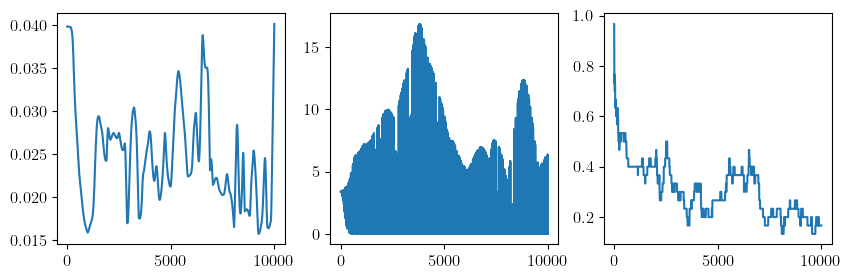

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].plot(np.arange(nb_epoch), eigenvals[:, -1])
axes[1].plot(th.arange(nb_epoch), train_loss)
axes[2].plot(th.arange(nb_epoch), test_loss)

## Note for later
- Think about the link between memory erasing and the edge of stability.
- Note that we are in a convex problem, so things can be analyzed with convex analysis, although our point is to understand the dynamics with a perspective that do not required convexity.